In [1]:
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F


In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
!pip install cfgrib xarray netCDF4
!pip install h5netcdf cftime

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## DATA PREPROCESSING
### Dataset gathering:

In [3]:
import xarray as xr
import pandas as pd

# Fixed location for Munich:
lat = 48.06
lon = 11.65

In [4]:
ds = xr.open_dataset("/content/data_stream-oper_stepType-accum.nc")
ds

<xarray.Dataset> Size: 70kB
Dimensions:     (valid_time: 1464, latitude: 1, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 12kB 2024-11-01 ... 2024-12-31T23...
  * latitude    (latitude) float64 8B 48.06
  * longitude   (longitude) float64 16B 11.4 11.65
    expver      (valid_time) <U4 23kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 12kB ...
    e           (valid_time, latitude, longitude) float32 12kB ...
    es          (valid_time, latitude, longitude) float32 12kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-11T14:27 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
point = ds.sel(latitude=lat, longitude=lon, method='nearest')
df = point.to_dataframe().reset_index()
df[['valid_time', 'tp', 'es', 'e']]
df.head()

,valid_time,number,latitude,longitude,expver,tp,e,es
0,2024-11-01 00:00:00,0,48.06,11.65,0001,0.000000e+00,0.000006,1.557055e-09
1,2024-11-01 01:00:00,0,48.06,11.65,0001,2.286339e-07,0.000004,-1.920853e-09
2,2024-11-01 02:00:00,0,48.06,11.65,0001,0.000000e+00,0.000003,-2.473826e-10
3,2024-11-01 03:00:00,0,48.06,11.65,0001,7.054711e-07,0.000005,-1.702574e-09
4,2024-11-01 04:00:00,0,48.06,11.65,0001,6.597446e-06,0.000003,-3.201421e-10


In [7]:
ds2 = xr.open_dataset("/content/data_stream-oper_stepType-avg.nc")
ds2

<xarray.Dataset> Size: 59kB
Dimensions:     (valid_time: 1464, latitude: 1, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 12kB 2024-11-01 ... 2024-12-31T23...
  * latitude    (latitude) float64 8B 48.06
  * longitude   (longitude) float64 16B 11.4 11.65
    expver      (valid_time) <U4 23kB ...
Data variables:
    avg_rorwe   (valid_time, latitude, longitude) float32 12kB ...
    avg_esrwe   (valid_time, latitude, longitude) float32 12kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-11T14:27 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
point = ds2.sel(latitude=lat, longitude=lon, method='nearest')
df2 = point.to_dataframe().reset_index()
df2[['valid_time', 'avg_rorwe', 'avg_esrwe']]
df2.head()

,valid_time,number,latitude,longitude,expver,avg_rorwe,avg_esrwe
0,2024-11-01 00:00:00,0,48.06,11.65,0001,0.000021,-2.619345e-10
1,2024-11-01 01:00:00,0,48.06,11.65,0001,0.000021,2.910383e-10
2,2024-11-01 02:00:00,0,48.06,11.65,0001,0.000021,3.346941e-10
3,2024-11-01 03:00:00,0,48.06,11.65,0001,0.000021,-4.074536e-10
4,2024-11-01 04:00:00,0,48.06,11.65,0001,0.000021,1.455192e-11


In [9]:
ds3 = xr.open_dataset("/content/data_stream-oper_stepType-instant.nc")
ds3

<xarray.Dataset> Size: 105kB
Dimensions:     (valid_time: 1464, latitude: 1, longitude: 2)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 12kB 2024-11-01 ... 2024-12-31T23...
  * latitude    (latitude) float64 8B 48.06
  * longitude   (longitude) float64 16B 11.4 11.65
    expver      (valid_time) <U4 23kB ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 12kB ...
    v10         (valid_time, latitude, longitude) float32 12kB ...
    t2m         (valid_time, latitude, longitude) float32 12kB ...
    msl         (valid_time, latitude, longitude) float32 12kB ...
    sp          (valid_time, latitude, longitude) float32 12kB ...
    tcc         (valid_time, latitude, longitude) float32 12kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-07-11T14:27 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
point = ds3.sel(latitude=lat, longitude=lon, method='nearest')
df3 = point.to_dataframe().reset_index()
df3[['valid_time', 'u10', 'v10', 't2m', 'msl', 'sp', 'tcc']]
df3.head()

,valid_time,number,latitude,longitude,expver,u10,v10,t2m,msl,sp,tcc
0,2024-11-01 00:00:00,0,48.06,11.65,0001,-0.216611,0.951273,281.403595,102696.125000,95883.00000,0.944381
1,2024-11-01 01:00:00,0,48.06,11.65,0001,0.018698,0.363130,280.974518,102668.906250,95863.78125,0.733485
2,2024-11-01 02:00:00,0,48.06,11.65,0001,-0.059412,0.003565,281.251099,102665.203125,95859.40625,0.706132
3,2024-11-01 03:00:00,0,48.06,11.65,0001,-0.070338,0.387085,281.067932,102678.773438,95862.75000,0.736486
4,2024-11-01 04:00:00,0,48.06,11.65,0001,0.073960,0.697486,281.002045,102694.101562,95874.43750,0.732920


In [11]:
df1_trimmed = df.drop(columns=['number', 'latitude', 'longitude', 'expver'])
df2_trimmed = df2.drop(columns=['number', 'latitude', 'longitude', 'expver'])
df3_trimmed = df3.drop(columns=['number', 'latitude', 'longitude', 'expver'])
# df4_trimmed = df4.drop(columns=['number', 'latitude', 'longitude', 'expver'])

# Merge on valid_time
merged_df = pd.merge(df1_trimmed, df2_trimmed, on='valid_time', how='inner')
merged_df = pd.merge(merged_df, df3_trimmed, on='valid_time', how='inner')

merged_df.head()

,valid_time,tp,e,es,avg_rorwe,avg_esrwe,u10,v10,t2m,msl,sp,tcc
0,2024-11-01 00:00:00,0.000000e+00,0.000006,1.557055e-09,0.000021,-2.619345e-10,-0.216611,0.951273,281.403595,102696.125000,95883.00000,0.944381
1,2024-11-01 01:00:00,2.286339e-07,0.000004,-1.920853e-09,0.000021,2.910383e-10,0.018698,0.363130,280.974518,102668.906250,95863.78125,0.733485
2,2024-11-01 02:00:00,0.000000e+00,0.000003,-2.473826e-10,0.000021,3.346941e-10,-0.059412,0.003565,281.251099,102665.203125,95859.40625,0.706132
3,2024-11-01 03:00:00,7.054711e-07,0.000005,-1.702574e-09,0.000021,-4.074536e-10,-0.070338,0.387085,281.067932,102678.773438,95862.75000,0.736486
4,2024-11-01 04:00:00,6.597446e-06,0.000003,-3.201421e-10,0.000021,1.455192e-11,0.073960,0.697486,281.002045,102694.101562,95874.43750,0.732920


In [ ]:
from google.colab import files
import os

merged_df.to_csv("dec2024.csv", index=False)

files.download("dec2024.csv")

# remove so that newer month's files can be uploaded again
for file in ["/content/data_stream-oper_stepType-accum.nc", "/content/data_stream-oper_stepType-avg.nc", "/content/data_stream-oper_stepType-instant.nc"]:
    os.remove(file)


In [ ]:
# import pandas as pd

# Load CSVs
# df1 = pd.read_csv("/content/jan-feb-2023.csv")
# df2 = pd.read_csv("/content/march-april-2023.csv")
# df3 = pd.read_csv("/content/may-june-2023.csv")
# df4 = pd.read_csv("/content/july-aug-2023.csv")
# df5 = pd.read_csv("/content/sept-oct-2023.csv")
# df6 = pd.read_csv("/content/nov-2023.csv")
# df7 = pd.read_csv("/content/dec-2023.csv")

# Combine all dataframes vertically
# combined_df = pd.concat([df1, df2, df3, df4, df5, df, df7], ignore_index=True)

# Save combined dataframe to CSV
# combined_df.to_csv("2023-jan-to-2023-dec.csv", index=False)
# files.download("2023-jan-to-2023-dec.csv")

In [ ]:
# df2 = pd.read_csv("/content/2023-jan-to-2023-nov.csv")
# df3 = pd.read_csv("/content/2024-jan-to-2024-dec.csv")

# combined_df = pd.concat([df2, df3], ignore_index=True)

# combined_df.to_csv("2023-jan-to-2024-dec.csv", index=False)
# files.download("2023-jan-to-2024-dec.csv")

### Dataset preparation:

In [15]:
import pandas as pd

df = pd.read_csv("/content/2023-jan-to-2024-dec.csv")

# df['valid_time'].dt.date.nunique()
df['valid_time'] = pd.to_datetime(df['valid_time'], format="%Y-%m-%d %H:%M:%S")
df['valid_time']

# Check if there are any missing hourly timestamps
df.set_index('valid_time').asfreq('H').isna().sum()

/tmp/ipython-input-15-1036455840.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.set_index('valid_time').asfreq('H').isna().sum()


,0
tp,0
e,0
es,0
avg_rorwe,0
avg_esrwe,0
u10,0
v10,0
t2m,0
msl,0
sp,0


In [16]:
df['valid_time'] = pd.to_datetime(df['valid_time'])

# Extract year and month
df['year'] = df['valid_time'].dt.year
df['month'] = df['valid_time'].dt.month

# Count number of hourly timesteps (rows) per (year, month)
monthly_timesteps = df.groupby(['year', 'month']).size().reset_index(name='num_hours')

print(monthly_timesteps)

    year  month  num_hours
0   2023      1        744
1   2023      2        672
2   2023      3        744
3   2023      4        720
4   2023      5        744
5   2023      6        720
6   2023      7        744
7   2023      8        744
8   2023      9        720
9   2023     10        744
10  2023     11        720
11  2023     12        744
12  2024      1        744
13  2024      2        696
14  2024      3        744
15  2024      4        720
16  2024      5        744
17  2024      6        720
18  2024      7        744
19  2024      8        744
20  2024      9        720
21  2024     10        744
22  2024     11        720
23  2024     12        744


In [17]:
import numpy as np
df['valid_time'] = pd.to_datetime(df['valid_time'], format="%Y-%m-%d %H:%M:%S")

df['hour'] = df['valid_time'].dt.hour
df['dayofyear'] = df['valid_time'].dt.dayofyear
df['year'] = df['valid_time'].dt.year

# Determine if each row is in a leap year (for correct encoding)
df['days_in_year'] = df['valid_time'].dt.is_leap_year.apply(lambda x: 366 if x else 365)

# Encode as cyclical features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Encode day of year (cycle = 365 or 366 depending on year)
df['doy_sin'] = np.sin(2 * np.pi * df['dayofyear'] / df['days_in_year'])
df['doy_cos'] = np.cos(2 * np.pi * df['dayofyear'] / df['days_in_year'])

df.head()

,valid_time,tp,e,es,avg_rorwe,avg_esrwe,u10,v10,t2m,msl,...,tcc,year,month,hour,dayofyear,days_in_year,hour_sin,hour_cos,doy_sin,doy_cos
0,2023-01-01 00:00:00,0.000000e+00,-0.000004,-1.120000e-09,0.000007,8.730000e-11,0.920039,2.793570,279.88953,102140.890,...,0.820788,2023,1,0,1,365,0.000000,1.000000,0.017213,0.999852
1,2023-01-01 01:00:00,0.000000e+00,-0.000004,1.860000e-09,0.000007,8.150000e-10,0.783752,2.891302,279.52502,102167.900,...,0.866896,2023,1,1,1,365,0.258819,0.965926,0.017213,0.999852
2,2023-01-01 02:00:00,0.000000e+00,-0.000005,3.200000e-10,0.000007,1.750000e-10,0.606461,2.904255,279.66800,102164.375,...,0.771990,2023,1,2,1,365,0.500000,0.866025,0.017213,0.999852
3,2023-01-01 03:00:00,0.000000e+00,-0.000005,-8.730000e-10,0.000007,6.840000e-10,0.654596,2.727947,279.64322,102152.510,...,0.704750,2023,1,3,1,365,0.707107,0.707107,0.017213,0.999852
4,2023-01-01 04:00:00,4.570000e-07,-0.000004,-9.900000e-10,0.000007,-8.150000e-10,0.971764,2.484983,279.04846,102160.090,...,0.542679,2023,1,4,1,365,0.866025,0.500000,0.017213,0.999852


In [19]:
df_featured = df.drop(columns=['year', 'month', 'hour', 'dayofyear', 'days_in_year'])
df_featured.head()

,valid_time,tp,e,es,avg_rorwe,avg_esrwe,u10,v10,t2m,msl,sp,tcc,hour_sin,hour_cos,doy_sin,doy_cos
0,2023-01-01 00:00:00,0.000000e+00,-0.000004,-1.120000e-09,0.000007,8.730000e-11,0.920039,2.793570,279.88953,102140.890,95474.770,0.820788,0.000000,1.000000,0.017213,0.999852
1,2023-01-01 01:00:00,0.000000e+00,-0.000004,1.860000e-09,0.000007,8.150000e-10,0.783752,2.891302,279.52502,102167.900,95502.140,0.866896,0.258819,0.965926,0.017213,0.999852
2,2023-01-01 02:00:00,0.000000e+00,-0.000005,3.200000e-10,0.000007,1.750000e-10,0.606461,2.904255,279.66800,102164.375,95501.900,0.771990,0.500000,0.866025,0.017213,0.999852
3,2023-01-01 03:00:00,0.000000e+00,-0.000005,-8.730000e-10,0.000007,6.840000e-10,0.654596,2.727947,279.64322,102152.510,95491.914,0.704750,0.707107,0.707107,0.017213,0.999852
4,2023-01-01 04:00:00,4.570000e-07,-0.000004,-9.900000e-10,0.000007,-8.150000e-10,0.971764,2.484983,279.04846,102160.090,95493.590,0.542679,0.866025,0.500000,0.017213,0.999852


In [ ]:
df_featured.to_csv("2023-2024_featured.csv", index=False)
files.download("2023-2024_featured.csv")

## DATA SLICING

In [20]:
merged_df = pd.read_csv("/content/2023-2024_featured.csv") # Read the csv data

final_df = merged_df
target_col = 'tp' # Defining our total percipitation column

X = merged_df.loc[:, [x for x in merged_df.columns.tolist() if x not in ['valid_time', target_col]]].values
y = np.array(merged_df[target_col])

# X, y
print(len(X[0]))
print(len(y))

14
17544


In [21]:
merged_df.shape

(17544, 16)

In [22]:
# Drop valid_time as we now have sin/cosine values for days and hours
merged_df = merged_df.drop(columns=['valid_time'])
data = merged_df
data.head()

,tp,e,es,avg_rorwe,avg_esrwe,u10,v10,t2m,msl,sp,tcc,hour_sin,hour_cos,doy_sin,doy_cos
0,0.000000e+00,-0.000004,-1.120000e-09,0.000007,8.730000e-11,0.920039,2.793570,279.88953,102140.890,95474.770,0.820788,0.000000,1.000000,0.017213,0.999852
1,0.000000e+00,-0.000004,1.860000e-09,0.000007,8.150000e-10,0.783752,2.891302,279.52502,102167.900,95502.140,0.866896,0.258819,0.965926,0.017213,0.999852
2,0.000000e+00,-0.000005,3.200000e-10,0.000007,1.750000e-10,0.606461,2.904255,279.66800,102164.375,95501.900,0.771990,0.500000,0.866025,0.017213,0.999852
3,0.000000e+00,-0.000005,-8.730000e-10,0.000007,6.840000e-10,0.654596,2.727947,279.64322,102152.510,95491.914,0.704750,0.707107,0.707107,0.017213,0.999852
4,4.570000e-07,-0.000004,-9.900000e-10,0.000007,-8.150000e-10,0.971764,2.484983,279.04846,102160.090,95493.590,0.542679,0.866025,0.500000,0.017213,0.999852


<Axes: >

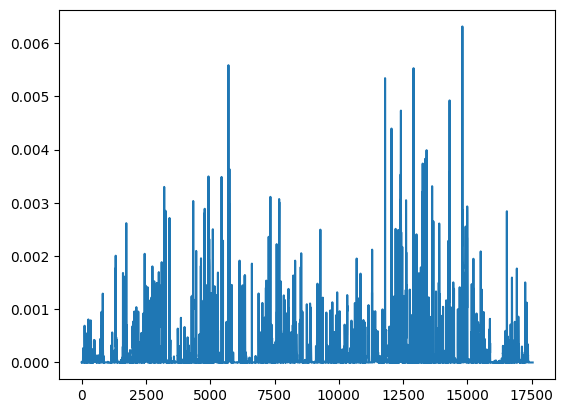

In [23]:
data["tp"].plot()

In [24]:
datapoints_total = data.shape[0]
t = int(datapoints_total*0.8)
tes = int(datapoints_total*0.1)
v = int(datapoints_total*0.1)
print(t, tes, v) # Define training, validation and testing rows

batch_size = 32
timesteps = 10 #no of past hours used as context
n_timeseries = data.shape[1] - 1
train_length = t
val_length = v
test_length = tes
target = "tp"

14035 1754 1754


In [25]:
X = np.zeros((len(data), timesteps, data.shape[1]-1)) #-> [samples, T, N]
y = np.zeros((len(data), timesteps, 1))               #-> [samples, T, 1]

print(len(X), len(X[0]))
print(len(y), len(y[0]))

17544 10
17544 10


In [26]:
# Create a sliding window of length timesteps
# For time t, X[t] = [x_{t-10}, x_{t-9}, ..., x_{t-1}]

for i, name in enumerate(list(data.columns[1:])):  # exclude target (column 0)
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

/tmp/ipython-input-26-1983734645.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")


In [27]:
# Same but now for the prediction y
# At time t, y[t] = [tp_{t-10}, ..., tp_{t-1}]

for j in range(timesteps):
    y[:, j, 0] = data["tp"].shift(timesteps - j - 1).fillna(method="bfill")

/tmp/ipython-input-27-1075131271.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y[:, j, 0] = data["tp"].shift(timesteps - j - 1).fillna(method="bfill")


In [28]:
# Predict the next-hour precipitation (tp_{t+1})
# set target[t] = tp_{t+1}

prediction_horizon = 1
target = data["tp"].shift(-prediction_horizon).fillna(method="ffill").values
target

/tmp/ipython-input-28-3740889065.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target = data["tp"].shift(-prediction_horizon).fillna(method="ffill").values


array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
# Remove first T samples (incomplete sequences)
# E.g., when T = 10, first prediction can only happen at t = 10

X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

X.shape, y.shape, target.shape

((17534, 10, 14), (17534, 10, 1), (17534,))

Slice into train, test and validation </br>
Keep X, target and Y (history)

In [30]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

In [31]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)


from sklearn.preprocessing import MinMaxScaler
def fit_and_transform(scaler, train, val, test):
    train_scaled = scaler.fit_transform(train.reshape(-1, train.shape[-1])).reshape(train.shape)
    val_scaled   = scaler.transform(val.reshape(-1, val.shape[-1])).reshape(val.shape)
    test_scaled  = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)
    return train_scaled, val_scaled, test_scaled

# Normalize X
scaler_X = MinMaxScaler()
X_train, X_val, X_test = fit_and_transform(scaler_X, X_train, X_val, X_test)

# Normalize y_his
scaler_y_his = MinMaxScaler()
y_his_train, y_his_val, y_his_test = fit_and_transform(scaler_y_his, y_his_train, y_his_val, y_his_test)

# Normalize target (1D case)
scaler_target = MinMaxScaler()
target_train = scaler_target.fit_transform(target_train.reshape(-1, 1)).flatten()
target_val   = scaler_target.transform(target_val.reshape(-1, 1)).flatten()
target_test  = scaler_target.transform(target_test.reshape(-1, 1)).flatten()

In [32]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

## DARNN MODEL

https://github.com/KurochkinAlexey/DA-RNN/blob/master/DARNN_NASDAQ.ipynb

In [33]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T

        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)

        #equation 8 matrices

        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)

    def safe_squeeze_last_dim(self, tensor):
      if tensor.dim() > 0 and tensor.size(-1) == 1:
          return tensor.squeeze(-1)
      return tensor


    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).cuda()

        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()

        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)

            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))

            # print("e_k_t shape:", e_k_t.shape)
            if e_k_t.dim() == 3:
                alpha_k_t = F.softmax(e_k_t, dim=1)
            elif e_k_t.dim() == 2:
                alpha_k_t = F.softmax(e_k_t, dim=1)
            elif e_k_t.dim() == 1:
                alpha_k_t = F.softmax(e_k_t, dim=0)
            else:
                raise ValueError(f"Unexpected dim for e_k_t: {e_k_t.dim()}")

            #normalize attention weights (equation 9)
            # alpha_k_t = F.softmax(e_k_t, dim=1)

            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :]

            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))

            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [34]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful

        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)

        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)

        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)

        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)

    def safe_squeeze_last_dim(self, tensor):
      if tensor.dim() > 0 and tensor.size(-1) == 1:
          return tensor.squeeze(-1)
      return tensor

    def forward(self, encoded_inputs, y):

        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)

            l_i_t = self.v_d(z1)
            # print("l_i_t shape:", l_i_t.shape)

            if l_i_t.dim() == 3:
                beta_i_t = F.softmax(l_i_t, dim=1)  # normal case, 3D tensor
            elif l_i_t.dim() == 2:
                beta_i_t = F.softmax(l_i_t, dim=1)  # still works, but check dims carefully
            elif l_i_t.dim() == 1:
                beta_i_t = F.softmax(l_i_t, dim=0)  # fallback to dim=0 if only 1D tensor
            else:
                raise ValueError(f"Unexpected tensor dimension for l_i_t: {l_i_t.dim()}")


            #normalized attention weights (equation 13)
            #beta_i_t = F.softmax(l_i_t, dim=1)

            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)

            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)

            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))

        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [35]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cuda()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cuda()
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [36]:
# define the model

model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1]).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [37]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Data loaders with batchsize 32
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

### Training & Validating:

Saving...
Iter:  0 train:  0.06291527989693999 val:  0.06531027650022327
mse:  1.3312358341401058e-07 mae:  0.0002026211651749906


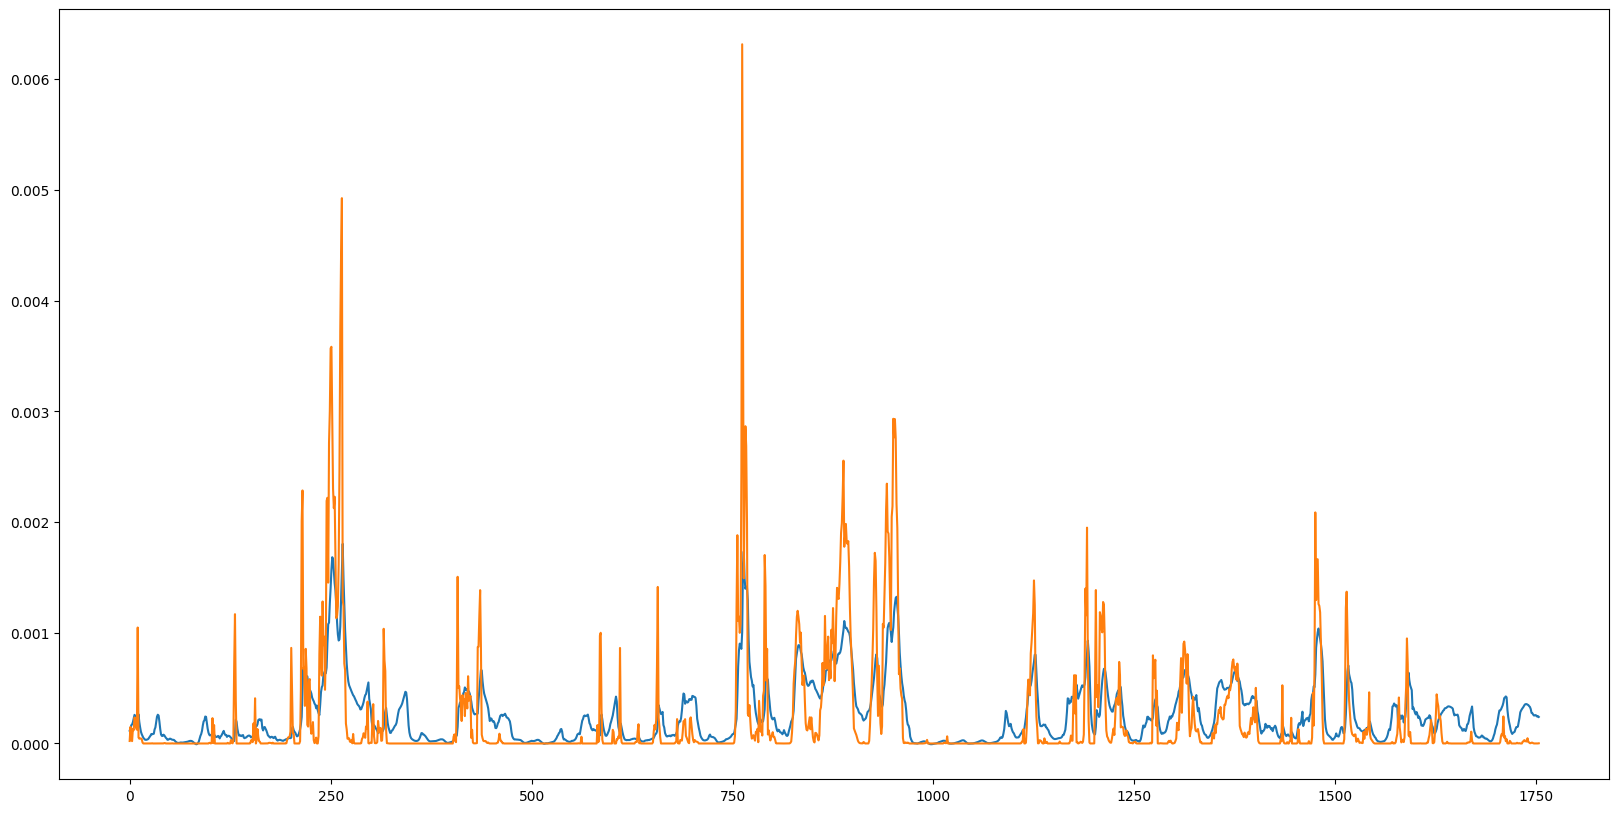

Saving...
Iter:  1 train:  0.04248528947452396 val:  0.046042708502520964
Saving...
Iter:  2 train:  0.03874199391311687 val:  0.04502452615118658
Saving...
Iter:  3 train:  0.03841270597682844 val:  0.043643974298664547
Saving...
Iter:  4 train:  0.038353891906506364 val:  0.04311228865155504
Iter:  5 train:  0.03823333903084526 val:  0.04336997933643462
Saving...
Iter:  6 train:  0.03800564643583687 val:  0.04269020308227136
Saving...
Iter:  7 train:  0.03814543434808521 val:  0.04255601398410092
Iter:  8 train:  0.038006663413400546 val:  0.04429072958781867
Iter:  9 train:  0.03772817060873457 val:  0.04477195448142096
Iter:  10 train:  0.03771416961882516 val:  0.04514415376581916
mse:  6.360554723068812e-08 mae:  0.0001457480961416374


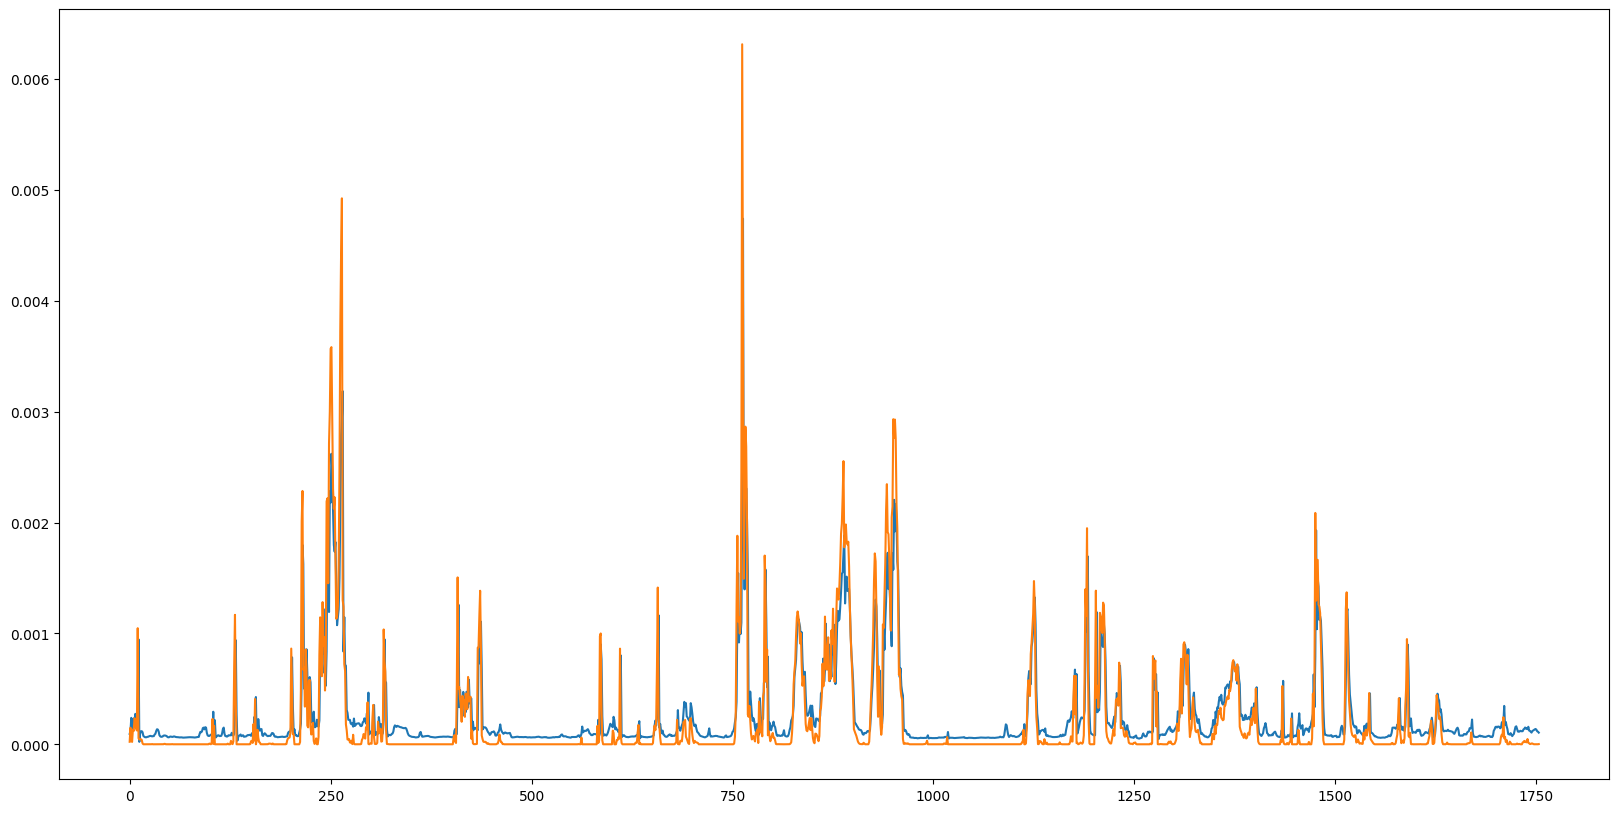

Iter:  11 train:  0.03764299095362003 val:  0.04297912780657598
Iter:  12 train:  0.03750192709475921 val:  0.04393637128821311
Iter:  13 train:  0.03721200580187683 val:  0.044988745463987255
Iter:  14 train:  0.03749330919555774 val:  0.044116351070927005
Saving...
Iter:  15 train:  0.03698082951944719 val:  0.04206497289177638
Iter:  16 train:  0.036983520933079994 val:  0.04326403991506318
Iter:  17 train:  0.03699999904264146 val:  0.04261634590695757
Iter:  18 train:  0.036946002133900674 val:  0.04237758075893823
Iter:  19 train:  0.03674470977289949 val:  0.0438591938470293
Iter:  20 train:  0.036459083657997306 val:  0.042079699173156015
mse:  5.5263348303993264e-08 mae:  0.00010670305342366293


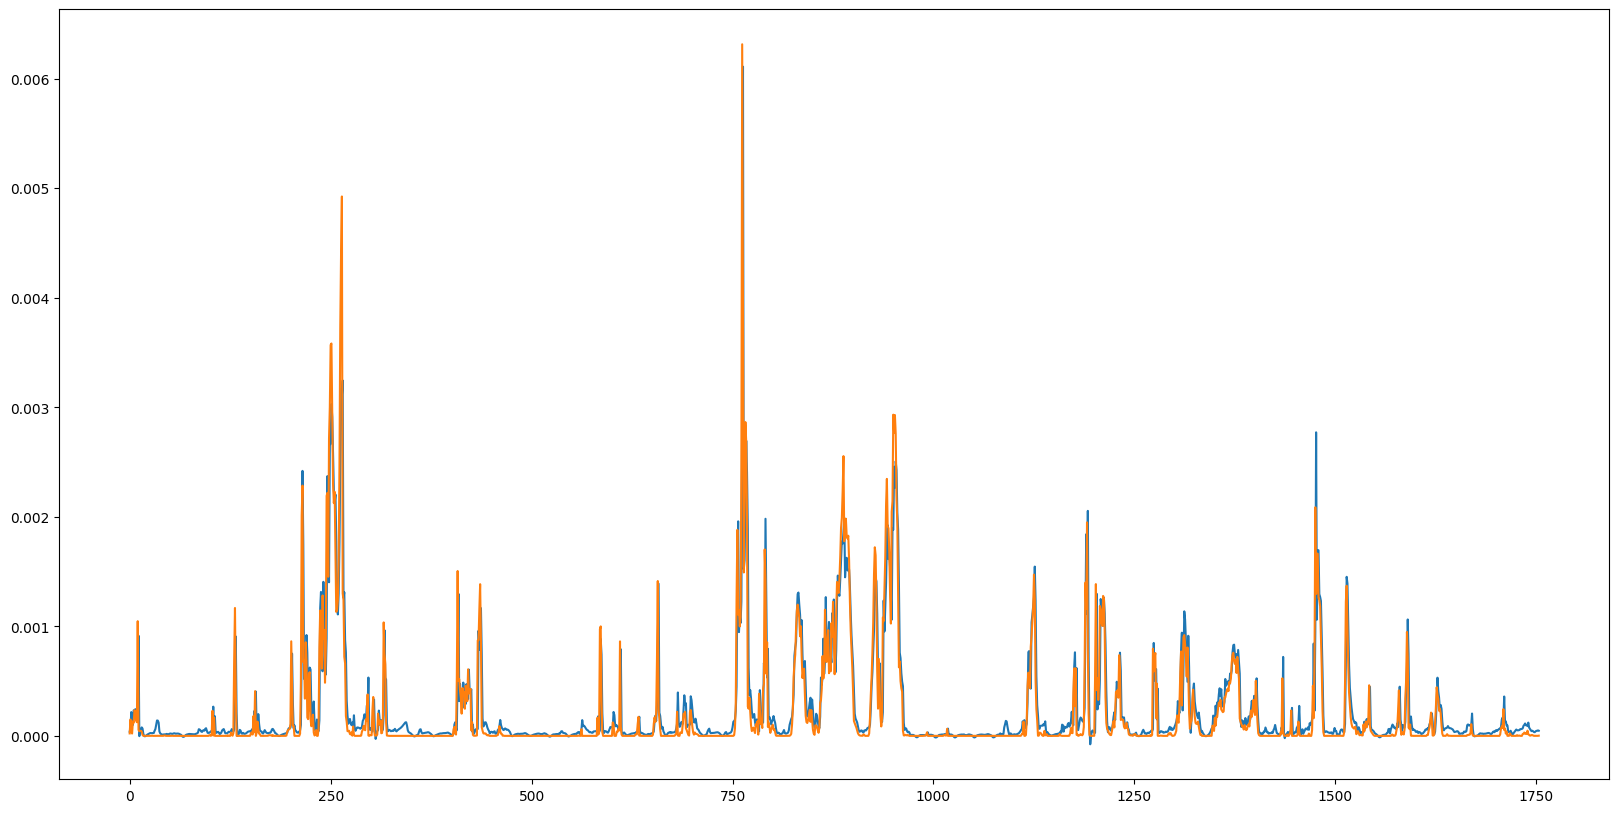

Iter:  21 train:  0.03641084932390001 val:  0.044444137780017025
Saving...
Iter:  22 train:  0.03657489678415877 val:  0.04188172634130405
Iter:  23 train:  0.03629017285035125 val:  0.04477346623198718
Iter:  24 train:  0.0362350548885963 val:  0.04282043771725576
Iter:  25 train:  0.03624077450133423 val:  0.041901393265696474
Iter:  26 train:  0.03623945125701517 val:  0.04328535659687873
Iter:  27 train:  0.0362887613392397 val:  0.043105414950496294
Iter:  28 train:  0.03606027029549447 val:  0.04326967464698838
Iter:  29 train:  0.035932721323311885 val:  0.04808513761563364
Iter:  30 train:  0.03580954963208305 val:  0.04292390278147683
mse:  5.750298079530253e-08 mae:  0.0001023047079198949


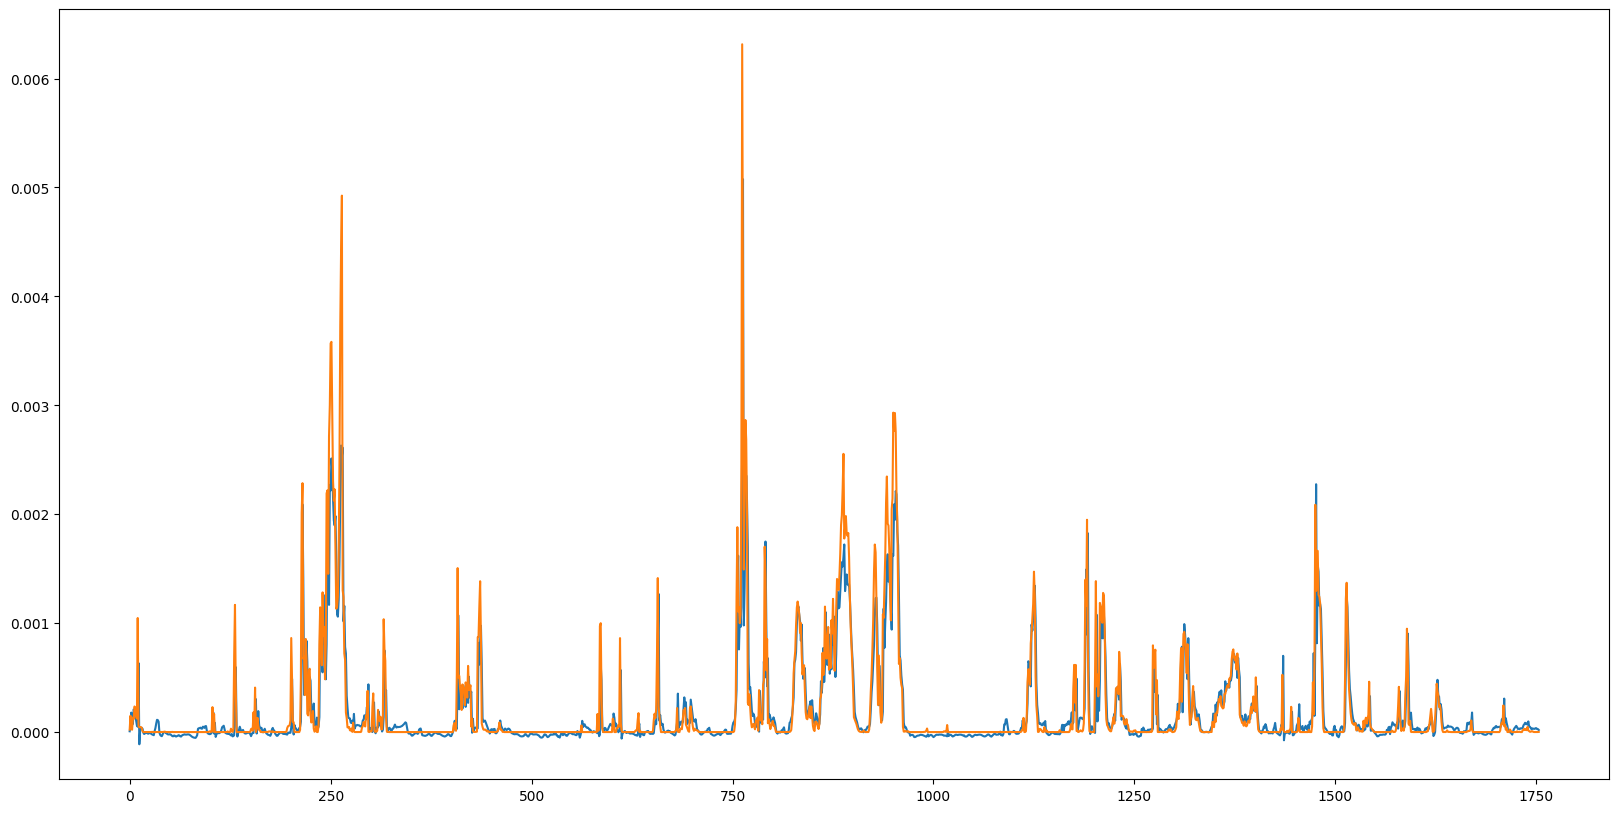

Saving...
Iter:  31 train:  0.03574990229910337 val:  0.04131513368599494
Iter:  32 train:  0.035972046818321696 val:  0.04148644834377461
Iter:  33 train:  0.03587478610210492 val:  0.043646038523584785
Iter:  34 train:  0.03600298082097993 val:  0.04342892886278676
Iter:  35 train:  0.03568470894454065 val:  0.04402511306310698
Iter:  36 train:  0.03573492024941632 val:  0.04425904548673071
Iter:  37 train:  0.03553021294276275 val:  0.04526434652258525
Iter:  38 train:  0.03551515559459418 val:  0.04272310005728594
Iter:  39 train:  0.035830737232169195 val:  0.04314189171283645
Iter:  40 train:  0.03574741711159121 val:  0.042528511123037294
mse:  5.6448487710177453e-08 mae:  0.00010505502645226149


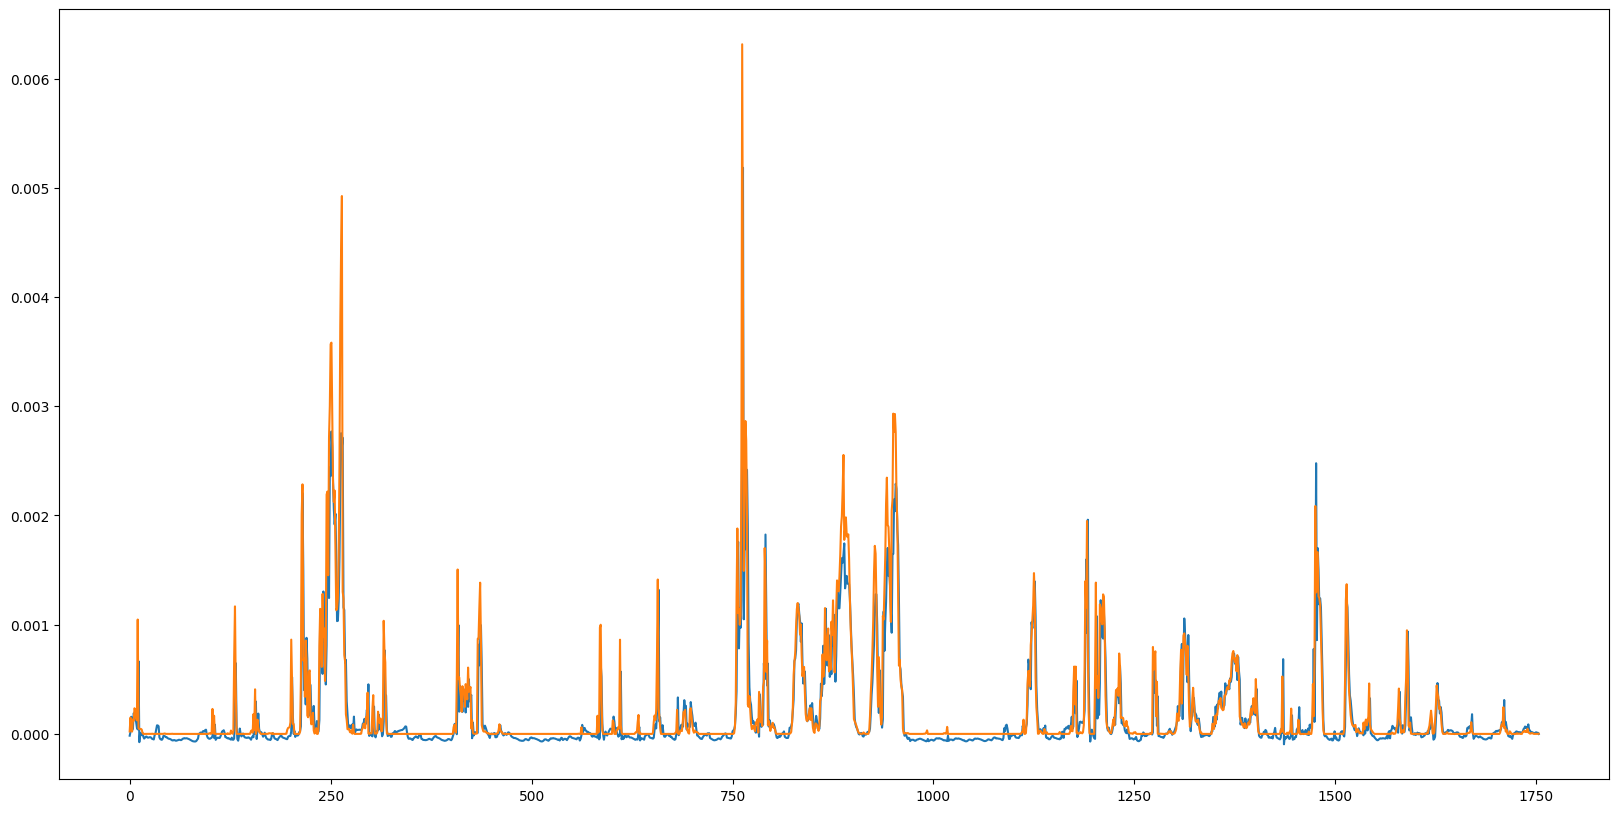

Iter:  41 train:  0.03546198250273412 val:  0.042675202902039334
Iter:  42 train:  0.0356073307815008 val:  0.04332641958232888
Iter:  43 train:  0.03559520966769731 val:  0.04406455583302247
Iter:  44 train:  0.03548143300716068 val:  0.04320846959325638
Iter:  45 train:  0.035327831270606805 val:  0.042477087162582416


In [38]:
epochs = 100
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        opt.zero_grad() # set grads as 0
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward() # compute loss w.r.t model weights/paramters
        mse_train += l.item()*batch_x.shape[0]
        opt.step() # update all weights/params
    epoch_scheduler.step()
    with torch.no_grad():  # don't calculate gradients, as we're in validation mode now so want to use the previously updated weights
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "darnn_nasdaq.pt")
        counter = 0
    else:
        counter += 1

    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

### Testing:

In [39]:
model.load_state_dict(torch.load("darnn_nasdaq.pt"))

<All keys matched successfully>

In [40]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        batch_y_h = batch_y_h.cuda()
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [41]:
# Denormalise the scaled values:

preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [456]:
# print(preds)

In [42]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

mse, mae

(6.9655605056080346e-09, 4.233648638757395e-05)

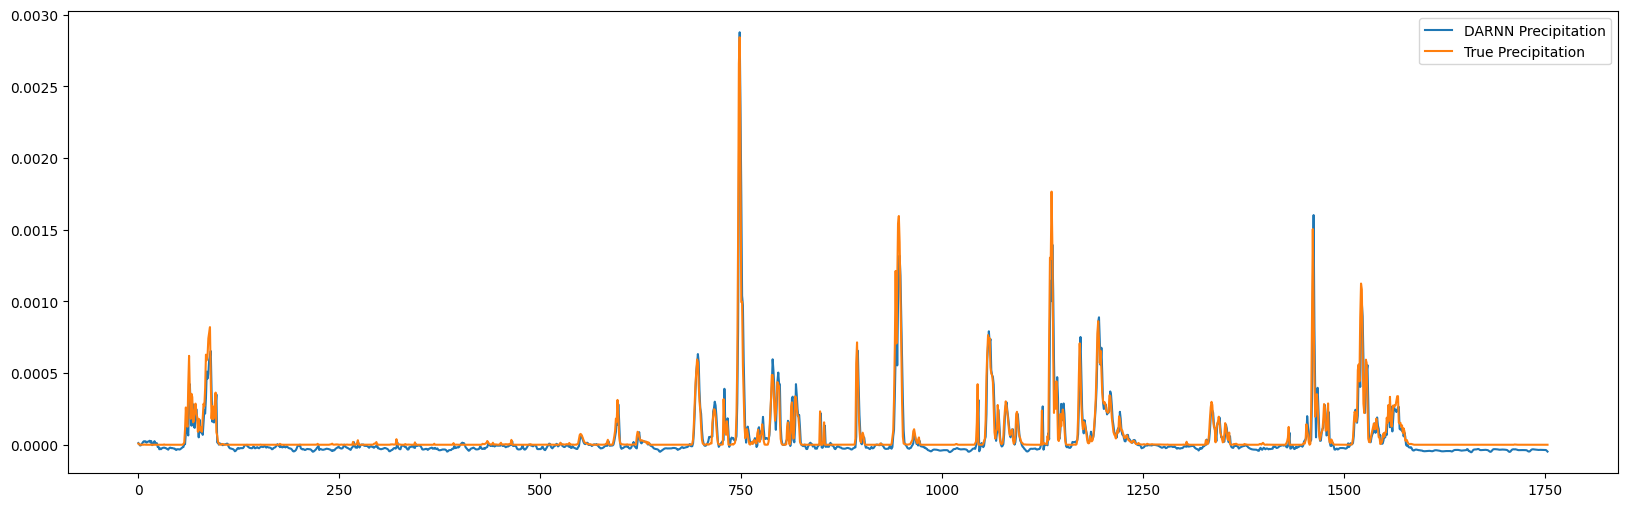

In [43]:
plt.figure(figsize=(20, 6))
plt.plot(preds, label="DARNN Precipitation")
plt.plot(true, label="True Precipitation")
plt.legend()
plt.show()

### Forecasting:

In [54]:
model.eval()

x_input = X_test_t[-1].unsqueeze(0).to("cuda")  # (1, 10, num_features)
print(x_input.shape)
y_input = y_his_test_t[-1].unsqueeze(0).to("cuda")  # (1, 10, 1)
print(y_input)

forecast_steps = 24 # Get next 24 hours
predictions = []

with torch.no_grad():
    for _ in range(forecast_steps):
        y_pred = model(x_input, y_input)  # shape: (1, 1)
        #if _ == 0:
          #print(x_input, y_input, y_pred)
        predictions.append(y_pred.item())

        # Maintain x_input shape: repeat last time step
        x_input = torch.cat([x_input[:, 1:, :], x_input[:, -1:, :]], dim=1)

        # Maintain y_input shape: append predicted y
        next_y = y_pred.unsqueeze(1)  # shape: (1, 1, 1)
        y_input = torch.cat([y_input[:, 1:, :], next_y], dim=1)

print(predictions[:10])  # before scaling
predictions = np.array(predictions).reshape(-1, 1)  # shape (N, 1)
predictions = np.clip(predictions, 0, 1)
predictions = scaler_target.inverse_transform(predictions).flatten()

print(predictions[:10])

torch.Size([1, 10, 14])
tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0')
[-0.00852520763874054, -0.01606696844100952, -0.02199682593345642, -0.026504337787628174, -0.029990553855895996, -0.03266538679599762, -0.034965768456459045, -0.03712630271911621, -0.03909370303153992, -0.04085741937160492]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


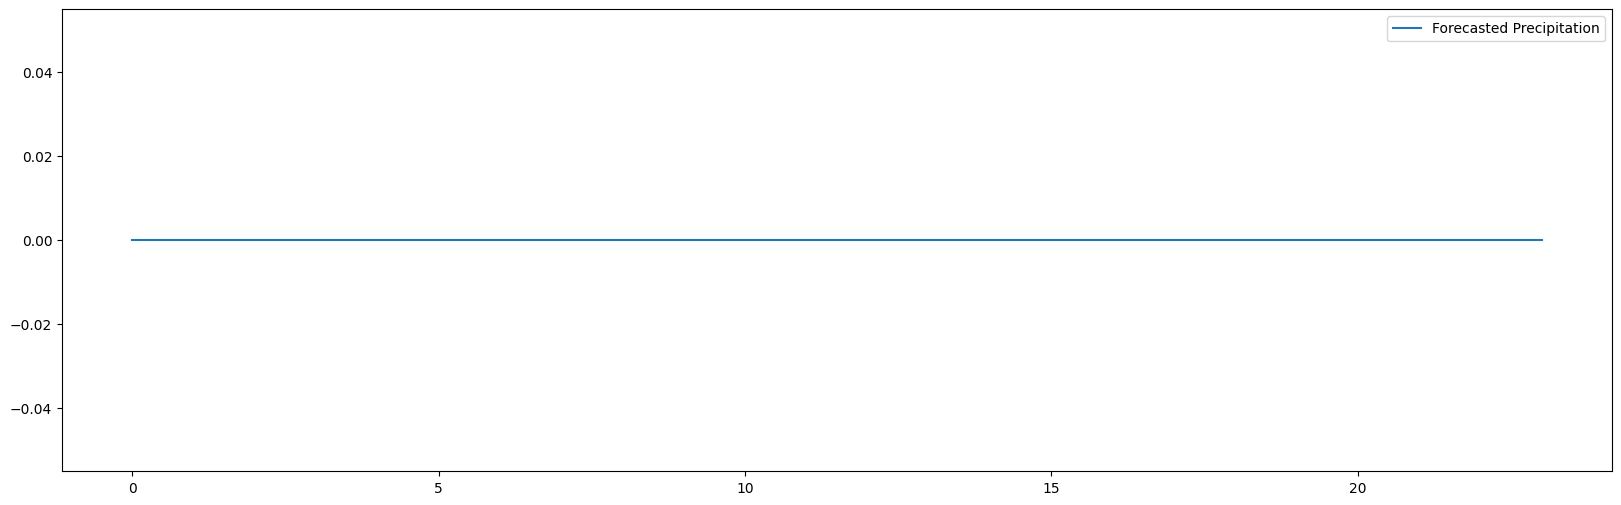

In [55]:
plt.figure(figsize=(20,6))
plt.plot(predictions, label="Forecasted Precipitation")
plt.legend()
plt.show()

### LSTM Model

In [59]:
import torch
import torch.nn as nn

class SlidingWindowLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_size, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 1))

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        output, _ = self.lstm(x)  # output: (batch_size, seq_len, hidden_size)
        last_output = output[:, -1, :]  # use output at last time step
        out = self.fc(last_output)      # final prediction
        return out

In [60]:
model = SlidingWindowLSTM(input_size=X_train.shape[2], hidden_size=64).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

# Data loaders with batch size 32 aswell
train_loader = DataLoader(TensorDataset(X_train_t, target_train_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, target_val_t), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_t, target_test_t), batch_size=32)

### Training & Validating:

Saving best model...
Epoch 0: Train RMSE = 0.060945, Val RMSE = 0.073411
Denormalized MSE:  1.6819742697373745e-07 MAE:  0.0002675381644147044


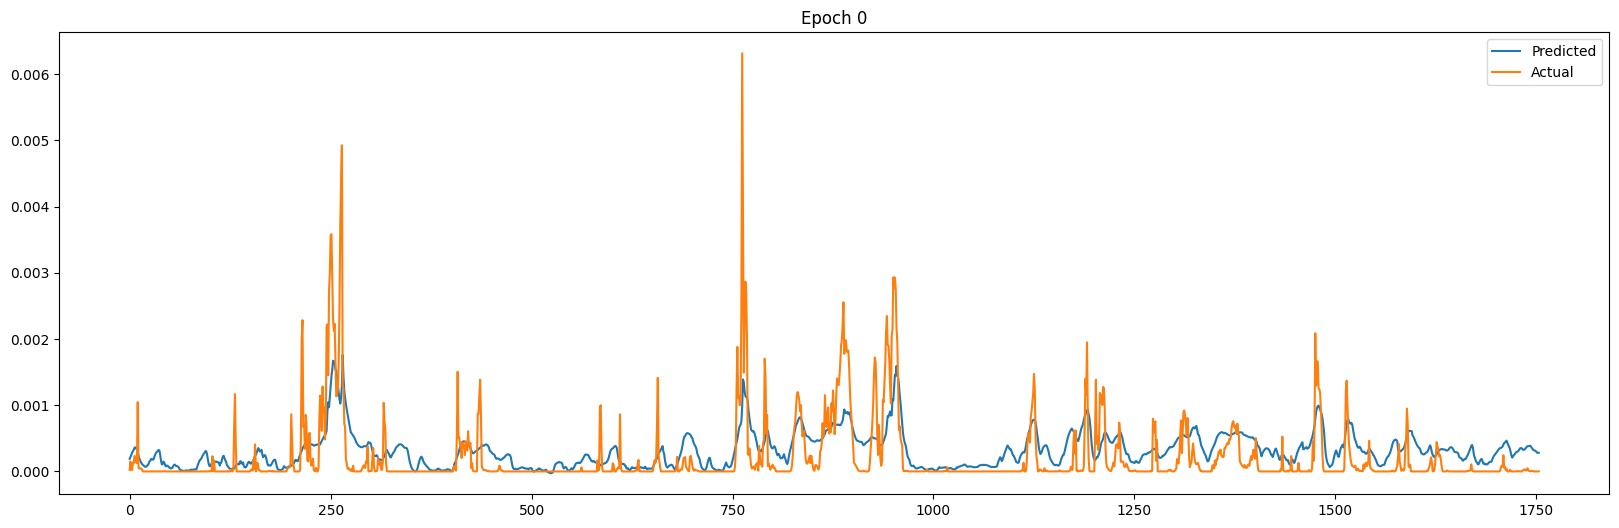

Saving best model...
Epoch 1: Train RMSE = 0.057410, Val RMSE = 0.070382
Saving best model...
Epoch 2: Train RMSE = 0.055699, Val RMSE = 0.066945
Saving best model...
Epoch 3: Train RMSE = 0.054736, Val RMSE = 0.066401
Epoch 4: Train RMSE = 0.053654, Val RMSE = 0.067754
Epoch 5: Train RMSE = 0.053134, Val RMSE = 0.067270
Epoch 6: Train RMSE = 0.052636, Val RMSE = 0.073242
Epoch 7: Train RMSE = 0.052150, Val RMSE = 0.066880
Saving best model...
Epoch 8: Train RMSE = 0.051455, Val RMSE = 0.064224
Saving best model...
Epoch 9: Train RMSE = 0.051522, Val RMSE = 0.063036
Epoch 10: Train RMSE = 0.051085, Val RMSE = 0.063411
Denormalized MSE:  1.254928939688249e-07 MAE:  0.00022334160099111367


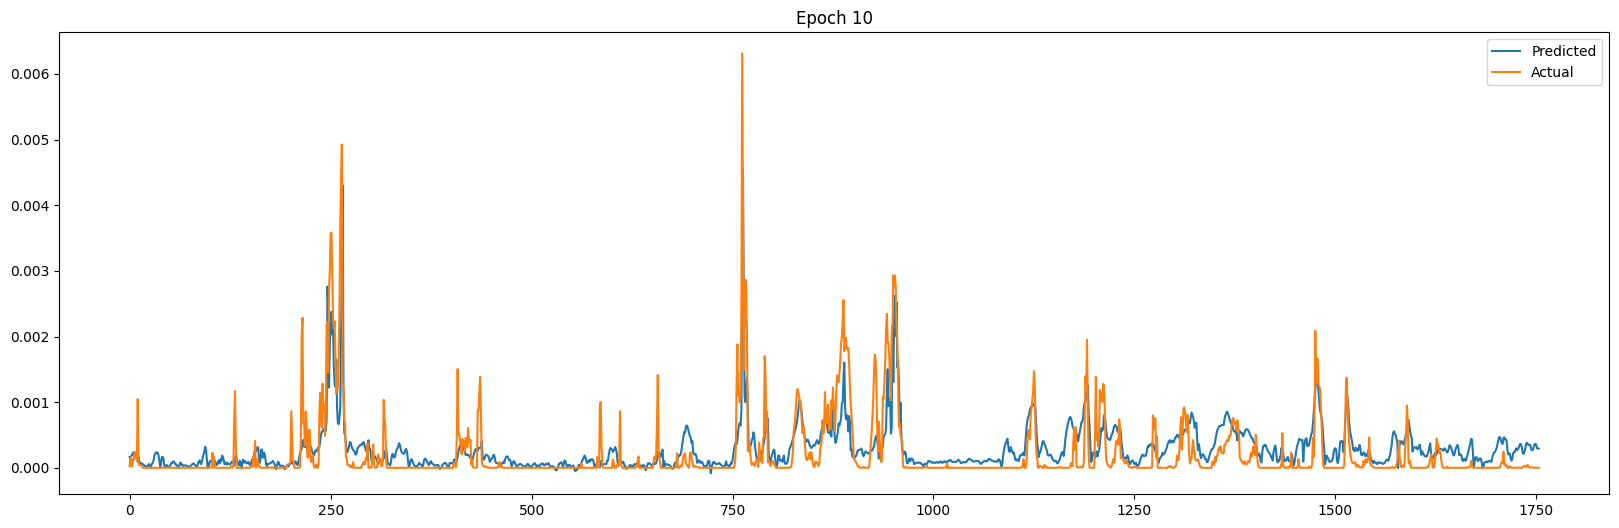

Epoch 11: Train RMSE = 0.050356, Val RMSE = 0.068343
Epoch 12: Train RMSE = 0.050107, Val RMSE = 0.067165
Epoch 13: Train RMSE = 0.049362, Val RMSE = 0.066611
Epoch 14: Train RMSE = 0.049777, Val RMSE = 0.063174
Epoch 15: Train RMSE = 0.049360, Val RMSE = 0.068661
Saving best model...
Epoch 16: Train RMSE = 0.048895, Val RMSE = 0.062673
Epoch 17: Train RMSE = 0.048898, Val RMSE = 0.066032
Saving best model...
Epoch 18: Train RMSE = 0.048282, Val RMSE = 0.062261
Epoch 19: Train RMSE = 0.047886, Val RMSE = 0.063574
Epoch 20: Train RMSE = 0.047233, Val RMSE = 0.066244
Denormalized MSE:  1.3695591367389158e-07 MAE:  0.0002373249713008052


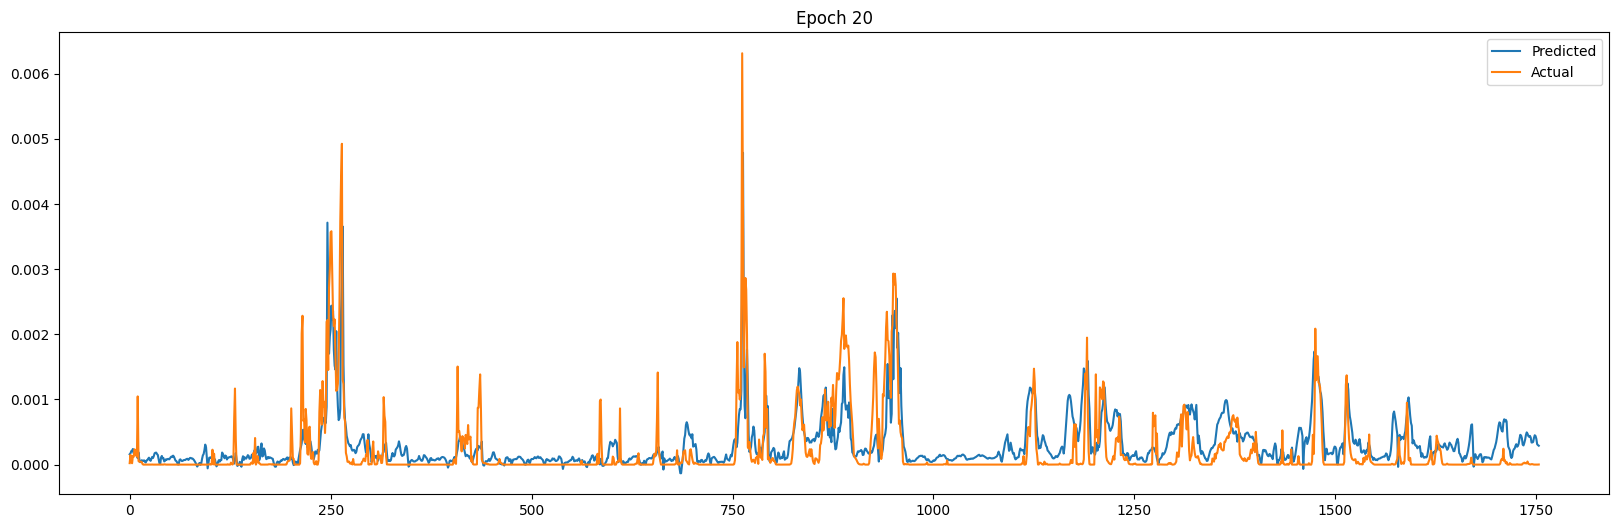

Epoch 21: Train RMSE = 0.047354, Val RMSE = 0.066562
Epoch 22: Train RMSE = 0.046898, Val RMSE = 0.065590
Epoch 23: Train RMSE = 0.046522, Val RMSE = 0.067448
Epoch 24: Train RMSE = 0.046657, Val RMSE = 0.065862
Epoch 25: Train RMSE = 0.045850, Val RMSE = 0.071662
Epoch 26: Train RMSE = 0.045581, Val RMSE = 0.062654
Epoch 27: Train RMSE = 0.045845, Val RMSE = 0.068885
Epoch 28: Train RMSE = 0.045312, Val RMSE = 0.066688
Epoch 29: Train RMSE = 0.045401, Val RMSE = 0.073604
Epoch 30: Train RMSE = 0.045028, Val RMSE = 0.076191
Denormalized MSE:  1.811759041242042e-07 MAE:  0.00027081997316636303


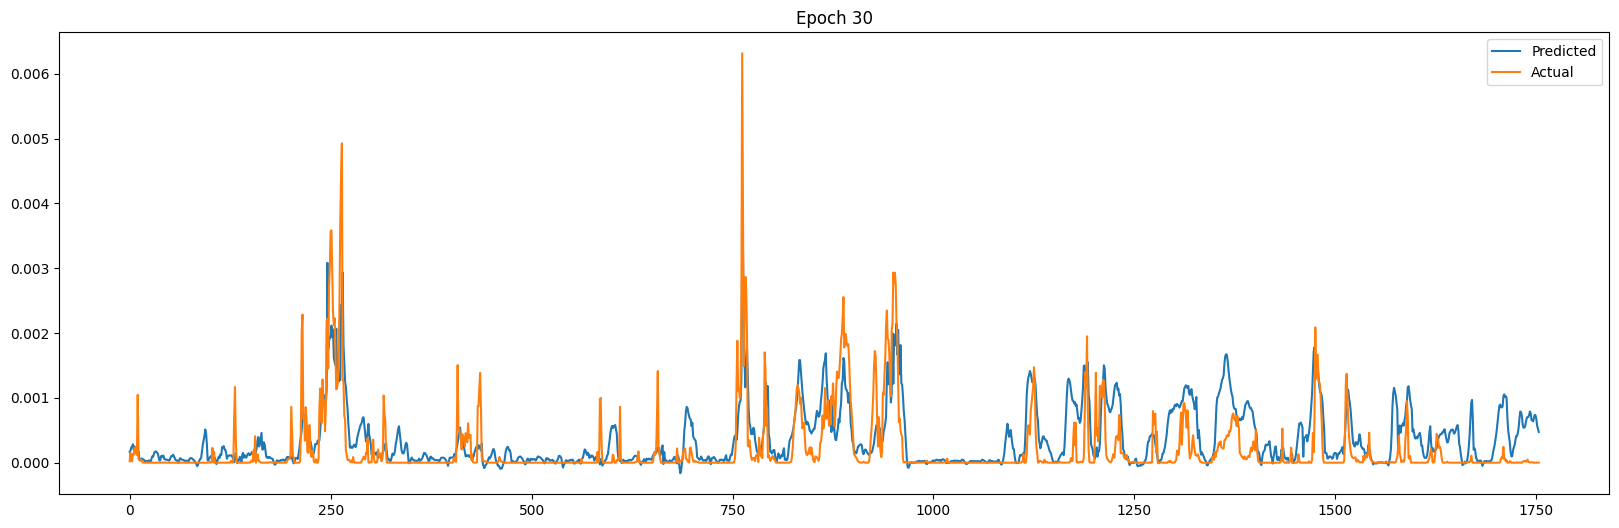

Epoch 31: Train RMSE = 0.044395, Val RMSE = 0.084645
Epoch 32: Train RMSE = 0.044365, Val RMSE = 0.077539
Early stopping triggered.


In [61]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 100
loss_fn = nn.MSELoss()
patience = 15
min_val_loss = float('inf')
counter = 0
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.9)

for epoch in range(epochs):
    model.train()
    mse_train = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

        opt.zero_grad()
        y_pred = model(batch_x).squeeze(1)
        loss = loss_fn(y_pred, batch_y)
        loss.backward()
        opt.step()

        mse_train += loss.item() * batch_x.size(0)

    scheduler.step()

    # Validation
    model.eval()
    mse_val = 0
    preds = []
    true = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            output = model(batch_x).squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss_fn(output, batch_y).item() * batch_x.size(0)

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    # Early stopping
    if min_val_loss > (mse_val / len(X_val))**0.5:
        min_val_loss = (mse_val / len(X_val))**0.5
        print("Saving best model...")
        torch.save(model.state_dict(), "lstm_precip.pt")
        counter = 0
    else:
        counter += 1

    if counter == patience:
        print("Early stopping triggered.")
        break

    # Print loss
    print(f"Epoch {epoch}: Train RMSE = {(mse_train / len(X_train))**0.5:.6f}, "
          f"Val RMSE = {(mse_val / len(X_val))**0.5:.6f}")

    # denormalize and evaluate every 10 epochs
    if epoch % 10 == 0:
        preds_denorm = preds * (target_train_max - target_train_min) + target_train_min
        true_denorm = true * (target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true_denorm, preds_denorm)
        mae = mean_absolute_error(true_denorm, preds_denorm)
        print("Denormalized MSE: ", mse, "MAE: ",mae)

        # Plot
        plt.figure(figsize=(20, 6))
        plt.plot(preds_denorm, label='Predicted')
        plt.plot(true_denorm, label='Actual')
        plt.legend()
        plt.title(f"Epoch {epoch}")
        plt.show()


### Testing:

In [62]:
model.load_state_dict(torch.load("lstm_precip.pt"))

<All keys matched successfully>

In [63]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x).squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss_fn(output, batch_y).item()*batch_x.size(0)
preds = np.concatenate(preds)
true = np.concatenate(true)

In [466]:
# print(preds)

[ 0.05419761  0.04978125  0.05669724 ... -0.00672482 -0.00744925
 -0.00773896]


In [64]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [468]:
# print(preds)

[ 3.02779248e-04  2.78106915e-04  3.16743644e-04 ... -3.75687383e-05
 -4.16158511e-05 -4.32342884e-05]


In [65]:
mse_LSTM = mean_squared_error(true, preds)
mae_LSTM = mean_absolute_error(true, preds)

In [66]:
mse_LSTM, mae_LSTM

(3.1980439871156476e-08, 9.662845116335534e-05)

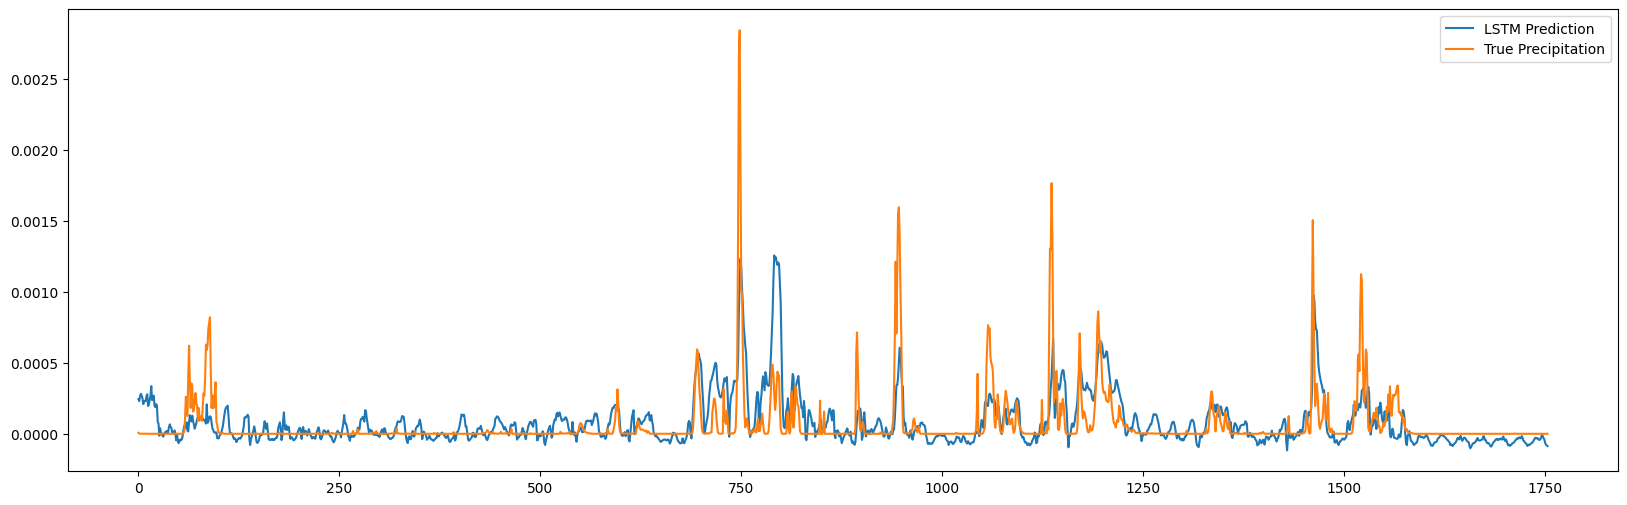

In [67]:
plt.figure(figsize=(20, 6))
plt.plot(preds, label="LSTM Prediction")
plt.plot(true, label="True Precipitation")
plt.legend()
plt.show()

### Forecasting:

In [68]:
model.eval()

# Start from last test input sequence, shape (1, seq_len, input_size)
x_input = X_test_t[-1].unsqueeze(0).to(device)

forecast_steps = 24
predictions = []

with torch.no_grad():
    for _ in range(forecast_steps):
        # Predict next step (output shape: (1, 1))
        y_pred = model(x_input).squeeze(1)  # (1)
        predictions.append(y_pred.item())

        # Maintain x_input shape: repeat last time step
        x_input = torch.cat([x_input[:, 1:, :], x_input[:, -1:, :]], dim=1)


print(predictions[:10]) # before scaling

# Min max values of percipitation:
max= 0.006314371
min = 0.0
predictions = np.array(predictions)
predictions = np.clip(predictions, 0, 1)
predictions = predictions * (max - min) + min
print(predictions[:10])

[-0.015486538410186768, -0.014414899051189423, -0.014005172997713089, -0.01402248814702034, -0.01405647024512291, -0.014082681387662888, -0.014117751270532608, -0.014138508588075638, -0.014150574803352356, -0.014154039323329926]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


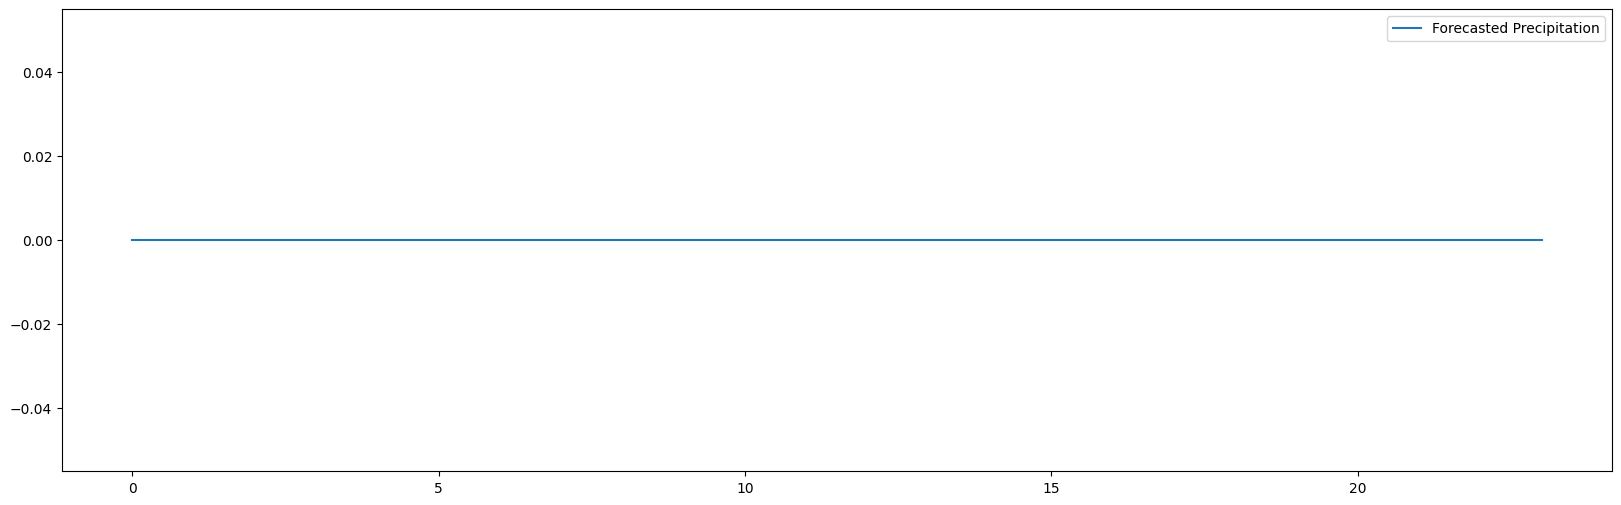

In [69]:
plt.figure(figsize=(20,6))
plt.plot(predictions, label="Forecasted Precipitation")
plt.legend()
plt.show()

## Linear Regression Model:

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Flatten the sequence for LR: (samples, timesteps * num_features)
X_train_lr = X_train.reshape(X_train.shape[0], -1)
X_val_lr = X_val.reshape(X_val.shape[0], -1)
X_test_lr = X_test.reshape(X_test.shape[0], -1)

In [71]:
lr = LinearRegression()
lr.fit(X_train_lr, target_train)

LinearRegression()

In [72]:
preds_lr = lr.predict(X_test_lr)

# Inverse scale
preds_lr = preds_lr * (target_train_max - target_train_min) + target_train_min
target_test_denorm = target_test * (target_train_max - target_train_min) + target_train_min

mse_lr = mean_squared_error(target_test_denorm, preds_lr)
mae_lr = mean_absolute_error(target_test_denorm, preds_lr)

print("Linear Regression MSE: ", mse_lr, "MAE: ",mae_lr)

Linear Regression MSE:  6.162159133094201e-08 MAE:  0.00020814269443490978


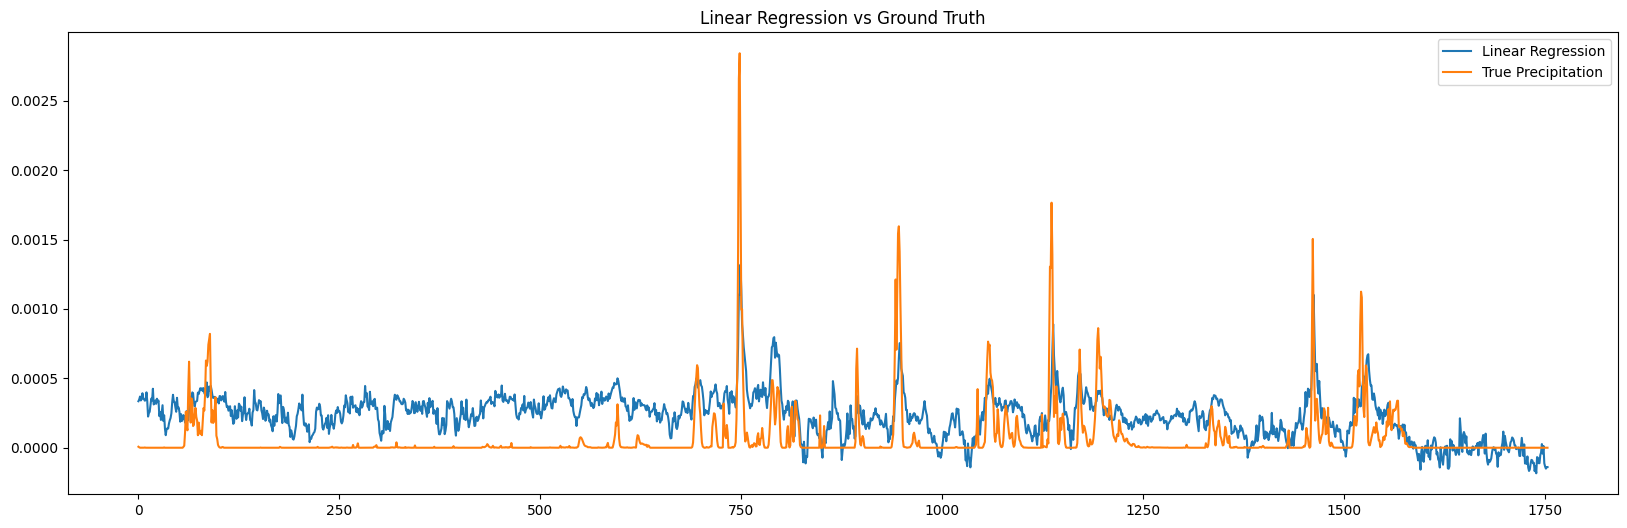

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(preds_lr, label="Linear Regression")
plt.plot(target_test_denorm, label="True Precipitation")
plt.legend()
plt.title("Linear Regression vs Ground Truth")
plt.show()

### Evaluation Results across all models:

In [74]:
# FOR LR:
mse_lr, mae_lr
# FOR LSTM:
mse_LSTM, mae_LSTM
# FOR DARNN:
mse, mae

rmse_lr = mse_lr ** 0.5
rmse_LSTM = mse_LSTM ** 0.5
rmse_darnn = mse ** 0.5

results_df = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM", "DA-RNN"],
    "MAE": [mae_lr, mae_LSTM, mae],
    "RMSE": [rmse_lr, rmse_LSTM, rmse_darnn]
})

# Display the table
print(results_df)

               Model       MAE      RMSE
0  Linear Regression  0.000208  0.000248
1               LSTM  0.000097  0.000179
2             DA-RNN  0.000271  0.000426
